In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Resizing,Rescaling,InputLayer,BatchNormalization,Flatten,Conv2D,MaxPool2D,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Reshape
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES =["angry","happy","sad"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 224,
    "DROPOUT_RATE" : 0.0 ,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "N_STRIDES" : 1,
    "KERNEL_SIZE" :3,
    "POOL_SIZE" : 2,
    "N_EPOCHS" : 20,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" : 3,
    "LEARNING_RATE" :0.001,

}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 307M/309M [00:17<00:00, 21.2MB/s]
100% 309M/309M [00:17<00:00, 18.1MB/s]


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/" > /dev/null

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 2278 files belonging to 3 classes.


In [ ]:
# for i in train_dataset.take(1) :
#   print(i)

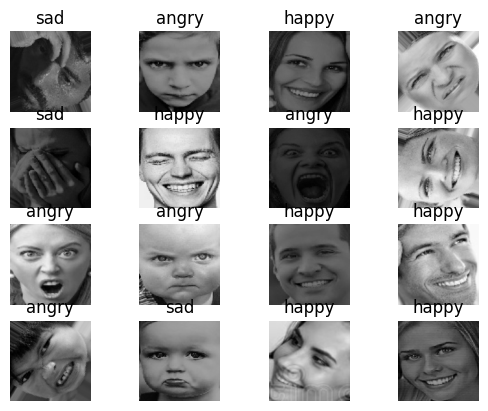

In [10]:
for images,labels in train_dataset.take(1):
  for i in range(16) :
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")


In [11]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

In [ ]:
model = tf.keras.Sequential([
                              InputLayer(input_shape=(None,None,3)),
                              resize_rescale_layers,

                              Conv2D(filters=CONFIGURATION['N_FILTERS'],kernel_size=CONFIGURATION['KERNEL_SIZE'],strides=CONFIGURATION['N_STRIDES'],
                                     padding='valid',activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),
                              Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

                              Conv2D(filters=CONFIGURATION['N_FILTERS']*2+4,kernel_size=CONFIGURATION['KERNEL_SIZE'],strides=CONFIGURATION['N_STRIDES'],
                                     padding='valid',activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),

                              Flatten(),
                              Dense(CONFIGURATION['N_DENSE_1'],activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
                              Dense(CONFIGURATION['N_DENSE_2'],activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax'),

])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)     

In [33]:

base_model = tf.keras.applications.MobileNet(weights="imagenet",include_top=False)


base_model.layers.pop()
base_model.layers.pop()

# for layer in base_model.layers:
#     layer.trainable = False

output_layer = base_model.layers[-1].output
x = GlobalAveragePooling2D()(output_layer)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)



In [34]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [27]:
loss_function= CategoricalCrossentropy()

In [28]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2,name = "top_k_accuracy")]

In [35]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics ,
    )

In [36]:
history = model.fit(
    training_dataset,
    validation_data= validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 45s 138ms/step - loss: 0.5900 - accuracy: 0.7511 - top_k_accuracy: 0.9191 - val_loss: 4.8626 - val_accuracy: 0.4320 - val_top_k_accuracy: 0.5843
Epoch 2/20
213/213 [==============================] - 27s 128ms/step - loss: 0.3821 - accuracy: 0.8444 - top_k_accuracy: 0.9543 - val_loss: 1.1469 - val_accuracy: 0.6611 - val_top_k_accuracy: 0.9030
Epoch 3/20
213/213 [==============================] - 27s 127ms/step - loss: 0.3019 - accuracy: 0.8829 - top_k_accuracy: 0.9678 - val_loss: 0.4926 - val_accuracy: 0.8363 - val_top_k_accuracy: 0.9539
Epoch 4/20
213/213 [==============================] - 28s 130ms/step - loss: 0.2470 - accuracy: 0.9041 - top_k_accuracy: 0.9747 - val_loss: 0.4069 - val_accuracy: 0.8459 - val_top_k_accuracy: 0.9543
Epoch 5/20
213/213 [==============================] - 27s 127ms/step - loss: 0.2104 - accuracy: 0.9148 - top_k_accuracy: 0.9804 - val_loss: 0.6121 - val_accuracy: 0.8174 - val_top_k_accuracy: 0.9416
Epoch

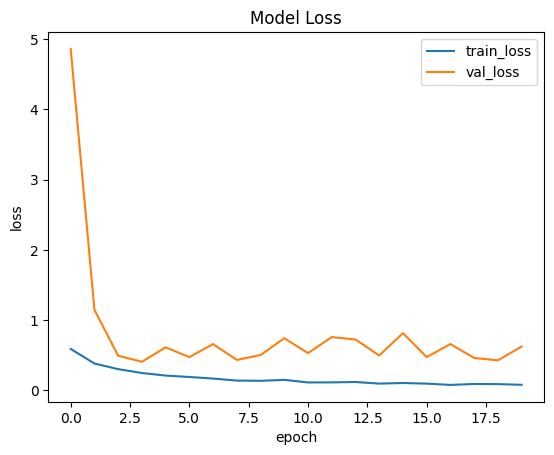

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

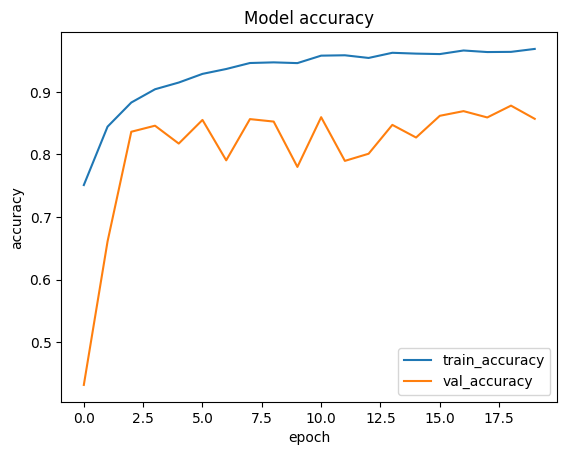

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [39]:
model.evaluate(validation_dataset)

72/72 [==============================] - 3s 38ms/step - loss: 0.6230 - accuracy: 0.8569 - top_k_accuracy: 0.9548


[0.6230223774909973, 0.8568919897079468, 0.9547848701477051]

In [40]:
predicted = []
labels = []
for im,label in validation_dataset :
  predicted.append(model(im))
  labels.append(label.numpy())

In [41]:
pred = np.argmax(predicted[:-1],axis=-1).flatten()
lab = np.argmax(labels[:-1],axis=-1).flatten()

[[435  30  47]
 [ 61 887  57]
 [ 78  53 624]]


Text(0.5, 58.7222222222222, 'predicted')

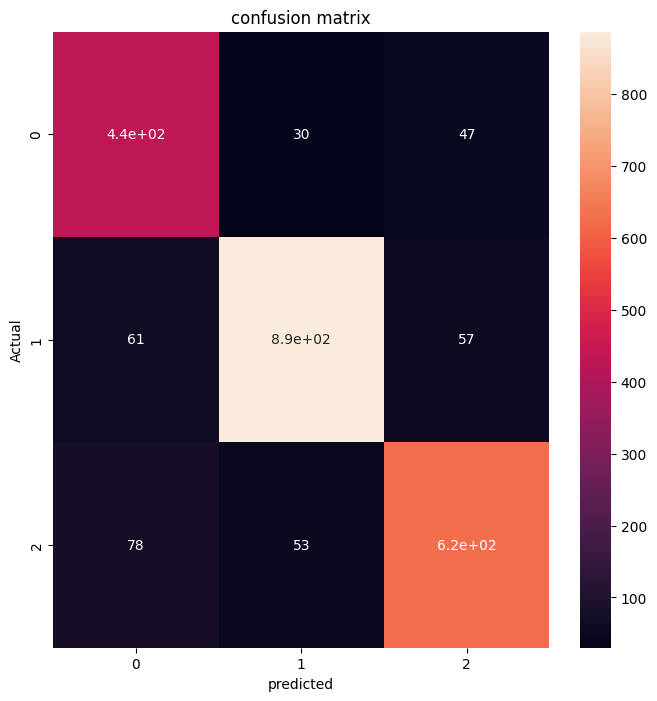

In [42]:
cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.ylabel('Actual')
plt.xlabel('predicted')